In [1]:
from __future__ import division
import timeit
import numpy as np 
import os
from Coeff import *
from Global_Variables import *
from Supplementary_Functions import *
from Load_Boundary_Conditions import *
from Test_engine import *
from Hydraulic_Calculation import *
import pycuda.driver as cuda
#import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
from Pointers import Pointers
from Pointers import PointersStruct
import skimage.io as io
%matplotlib inline
import timeit

4246
[0 0 0 0]


In [2]:
cuda.init()
dev = cuda.Device(1) # the number of GPU
ctx = dev.make_context()
kwargs = {"h": h, "hsnham": hsnham, "VISCOINDX" : VISCOINDX, "H_moi": H_moi, "bienQ" : bienQ,\
          "moci" : moci ,"mocj" : mocj, "dauj": dauj, "daui" : daui, "cuoii" : cuoii, "cuoij" : cuoij,\
          "Tsxw" : Tsxw, "Tsyw" : Tsyw, "khouot" : khouot, "boundary_type" : boundary_type,\
          "u": u, "v": v, "z" : z, "t_u": t_u, "t_v": t_v, "t_z": t_z, "Htdu": Htdu, "Htdv" : Htdv,\
          "Kx1" : Kx1, "Ky1" : Ky1, "htaiz" : htaiz,\
          "bc_up": bc_up, "bc_down": bc_down, "bc_left": bc_left, "bc_right" : bc_right,\
          "ubt" : ubt, "ubp" : ubp, "vbt" : vbt, "vbd" : vbd, "hi": hi, \
          "FS" : FS, 'CC_u' : CC_u, 'CC_d' : CC_d, 'CC_l' : CC_l, 'CC_r' : CC_r,\
          "VTH": VTH, "Kx" : Kx, "Ky" : Ky, "Fw" : Fw, "Qbx" : Qbx, "Qby" : Qby, "dH" : dH}
pointers = Pointers(ctx,dtype=np.float64,**kwargs)
# pointers = Pointers(ctx,**kwargs)

pd = pointers.alloc_on_device_only(N, M)
pc = pointers.alloc()
global_attributes = [np.int32(M), np.int32(N),\
                pc['bienQ'], pc['daui'], pc['dauj'], pc['cuoii'], pc['cuoij'], pc['moci'], pc['mocj'], pc['khouot'], pc['boundary_type'], \
                pc['h'], pc['v'], pc['u'], pc['z'], pc['t_u'], pc['t_v'], pc['t_z'], pc['Htdu'], pc['Htdv'], pc['H_moi'], pc['htaiz'],\
                pc['ubt'], pc['ubp'], pc['vbt'], pc['vbd'], \
                pc['hsnham'], pc['VISCOINDX'], pc['Kx1'], pc['Ky1'], pc['Tsyw'], pc['Tsxw'],\
                pc['bc_up'], pc['bc_down'], pc['bc_left'], pc['bc_right'], pc['hi'],\
                pc['FS'], pc['CC_u'], pc['CC_d'], pc['CC_l'], pc['CC_r'],\
                pc['VTH'], pc['Kx'], pc['Ky'], pc['Fw'], pc['Qbx'], pc['Qby'], pc['dH']]

auxilary_arrays = [pd['a1'], pd['b1'], pd['c1'], pd['d1'], pd['a2'], pd['c2'], pd['d2'],\
                pd['f1'], pd['f2'], pd['f3'], pd['f5'],\
                pd['AA'], pd['BB'], pd['CC'], pd['DD'],\
                pd['x'], pd['Ap'], pd['Bp'], pd['ep'], pd['SN'] ]


In [3]:
print pc['FS']

In [4]:
# arg_struct_size = 44 * np.intp(0).nbytes + 8;
#     arr_struct_size = 20 * np.intp(0).nbytes;
arg_struct_ptr = cuda.mem_alloc(np.intp(0).nbytes * (len(global_attributes) - 2) + 8)
arr_struct_ptr = cuda.mem_alloc(np.intp(0).nbytes * len(auxilary_arrays))
arg_struct = PointersStruct(global_attributes, arg_struct_ptr)
arr_struct = PointersStruct(auxilary_arrays, arr_struct_ptr, structtype='ARR')
pointers.toDevice(['h', 'hsnham', 'VISCOINDX', 'bienQ', 'Tsyw', 'Tsxw', 'boundary_type', 'bc_up', 'bc_down', 'bc_left', 'bc_right',\
                  'u', 'v', 'z', 'CC_u', 'CC_d', 'CC_l', 'CC_r'])
ctx.synchronize()

supplement = open("tmp.cu").read()
supmod = SourceModule(supplement, include_dirs = [os.getcwd()])
init_Kernel = supmod.get_function("Onetime_init")
Find_Calculation_limits_x = supmod.get_function("Find_Calculation_limits_Horizontal")
Find_Calculation_limits_y = supmod.get_function("Find_Calculation_limits_Vertical")
gpu_Htuongdoi  = supmod.get_function("Htuongdoi")
preprocess = supmod.get_function("preprocess_data")

block_2d = (min(32, M + 3), 1, 1)
grid_2d = ((M + 3) // min(32, M + 3) + 1, N + 3, 1)
init_Kernel(arg_struct_ptr, block=block_2d, grid=grid_2d)
ctx.synchronize()
Find_Calculation_limits_x(arg_struct_ptr, block=(32, 1, 1), grid=(1, N, 1))
Find_Calculation_limits_y(arg_struct_ptr, block=(32, 1, 1), grid=(1, M, 1))
gpu_Htuongdoi(arg_struct_ptr, block=block_2d, grid=grid_2d)
ctx.synchronize()
preprocess(arg_struct_ptr, block=(32, 1, 1), grid = (1, 1, 1))


/home/huongnm/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: The CUDA compiler succeeded, but said the following:
/home/Pearl/mia/Hydist/constant.cuh(154): warning: missing return statement at end of non-void function "locate_segment_v"

/home/Pearl/mia/Hydist/constant.cuh(178): warning: missing return statement at end of non-void function "locate_segment_u"


  # This is added back by InteractiveShellApp.init_path()


In [5]:
def load_input_and_initialize():
    TinhKhoUot()
    Htuongdoi()
    K_factor()
    GiatriHtaiZ()
    #Initial_condition(Dirs['U_file'], Dirs['V_file'], Dirs['Z_file']) # this can load new 
    # Load initial condition (tinh tiep hoac tinh tu dau)
    Find_Calculation_limits()
load_input_and_initialize()

In [6]:
# gpu_boundary_type = np.zeros(boundary_type.shape, dtype=np.int32)
# cuda.memcpy_dtoh(gpu_boundary_type, pc['boundary_type'])
# gpu_left = np.zeros(bc_left.shape, dtype=np.float32)
# cuda.memcpy_dtoh(gpu_left, pc['bc_left'])
# gpu_bienQ = np.zeros(bienQ.shape, dtype=np.int32)
# cuda.memcpy_dtoh(gpu_bienQ, pc['bienQ'])
# gpu_htdu = np.zeros(Htdu.shape,dtype=np.float32)
# gpu_htdv = np.zeros(Htdv.shape,dtype=np.float32)
# gpu_daui = np.zeros(daui.shape,dtype=np.int32)
# gpu_dauj = np.zeros(dauj.shape,dtype=np.int32)
# gpu_cuoii = np.zeros(cuoii.shape,dtype=np.int32)
# gpu_cuoij = np.zeros(cuoij.shape,dtype=np.int32)
# gpu_khouot = np.ones(khouot.shape,dtype=np.int32)
# gpu_tz = np.zeros(t_u.shape, dtype=np.float32)
# gpu_tu = np.zeros(t_u.shape, dtype=np.float32)
# gpu_tv = np.zeros(t_u.shape, dtype=np.float32)

# pointers.extract({"Htdu" : gpu_htdu, "Htdv" : gpu_htdv, "daui" : gpu_daui, "cuoii" : gpu_cuoii, "dauj" : gpu_dauj, "cuoij" : gpu_cuoij, "khouot" : gpu_khouot })
# # print np.where(gpu_htdu[:,10] != 0)
# err_htdv = np.where(abs(gpu_htdv - Htdv ) > 1e-6)
# err_htdu = np.where(abs(gpu_htdu - Htdu ) > 1e-6)
# err_daui = np.where(abs(gpu_daui - daui ) != 0)
# err_dauj = np.where(abs(gpu_dauj - dauj ) != 0)
# err_cuoii = np.where(abs(gpu_cuoii - cuoii ) != 0)
# err_cuoij = np.where(abs(gpu_cuoij - cuoij ) != 0)
# err_ku = np.where(abs(gpu_khouot - khouot) != 0)   
# print khouot[:,5]
# print gpu_khouot[:, 5]
# print 'khouot:', err_ku
# print "Htdu:",  err_htdu
# print "Htdv:",  err_htdv
# print "daui :",  err_daui
# print "dauj :",  err_dauj
# print "cuoii:", err_cuoii
# print "cuoij:", err_cuoij   


In [ ]:
hours = 0
mins = 0
secs = 1
Tmax = hours*3600 + mins* 60 + secs
plot = False
debug = True
print_time = 0
interval = 1
export = False

('Tmax = ', 1)
('N, M : ', 464, ' ', 324)


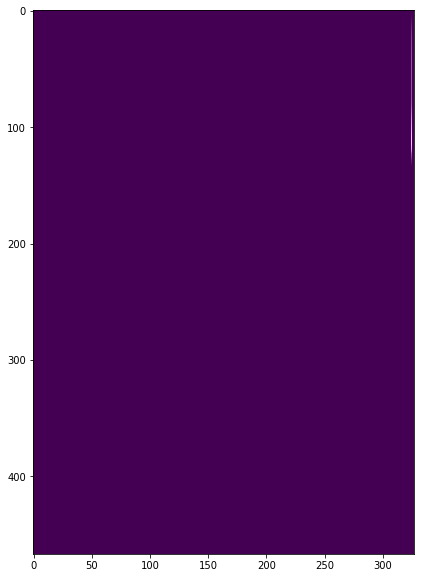

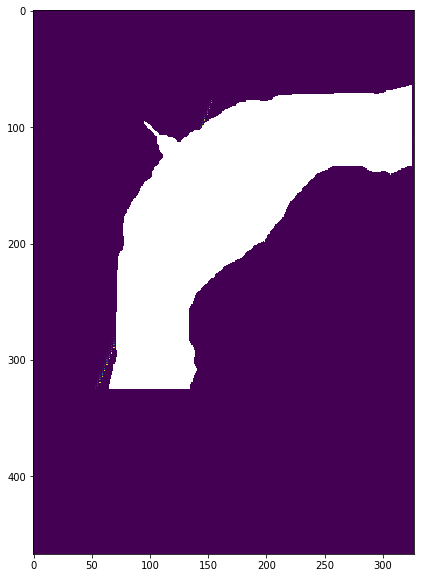

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/huongnm/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/huongnm/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/huongnm/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/huongnm/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/huongnm/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 403, in execute_request
    sys.stderr.flush()
  File "/home/huongnm/anaconda2/lib/python2.7/si

In [ ]:
start_time = timeit.default_timer()
ulist, vlist, zlist = hydraulic_Calculation(Tmax, pointers, arg_struct_ptr, arr_struct_ptr, supmod, ctx,\
                                            debug=debug, plot=plot, interval=interval, export=export, print_time=print_time)
stop_time = timeit.default_timer()
print stop_time - start_time

In [ ]:
# print ulist[2][1] 
ulist = np.array(ulist, dtype=np.float64)
vlist = np.array(vlist, dtype=np.float64)
zlist = np.array(zlist, dtype=np.float64)



In [ ]:
print CC_u

In [ ]:
import skimage.io as io

In [ ]:
print np.where(FS != 0)

In [ ]:
io.imsave("gpu_U.tif" ,ulist )
io.imsave("gpu_V.tif" ,vlist )
io.imsave("gpu_Z.tif" ,zlist )

In [ ]:
print len(U)

In [ ]:
t = 0
err = []
# print np.max(abs(U - ulist[:1199, 1 : N + 1, 1 : M + 1]))
# print np.max(abs(V - vlist[:1199, 1 : N + 1, 1 : M + 1]))
# print np.max(abs(Z - zlist[:1199, 1 : N + 1, 1 : M + 1]))

for i in range(50,len(U)):
    print i, 0.25 * (i + 1)
#     plt.imshow(U[i,56:70, 10:55])
#     plt.show()
#     plt.imshow(ulist[i, 57:71, 11:56])
#     plt.show()
    print 'u', np.max(abs(U[i] - ulist[i, 1 : N + 1, 1 : M + 1]))
    print 'z', np.max(abs(Z[i] - zlist[i, 1 : N + 1, 1 : M + 1]))
    print 'v', np.max(abs(V[i] - vlist[i, 1 : N + 1, 1 : M + 1]))

#     print Z[i, 258, 227] - zlist[i, 259, 228]
#     print Z[i, 258, 230]  - zlist[i, 259, 231]
#     print V[i, 258, 230] - vlist[i, 259, 231]
    if i > 80 and i < 100:
        plt.plot(Z[i, 258, 235:240])
        plt.show()
        plt.plot(zlist[i, 259,236:241])
        plt.show()
        
#         plt.imshow(h[250:260,235:246])
#         plt.show()
#         plt.imshow(abs(U[i,249:259,234:245 ] - ulist[i, 250:260,235:246]))
#         plt.show()
#         plt.imshow(abs(Z[i,249:259,234:245] - zlist[i, 250:260,235:246]))
#         plt.show()
#         plt.imshow(abs(V[i,249:259,234:245] - vlist[i, 250:260,235:246]))
#         plt.show()
#         plt.plot(zlist[i, 255:259, 245])
#         print zlist[i, 258, 240]
        

#    
#     print 'v', np.max(abs(V[i] - vlist[i, 1 : N + 1, 1 : M + 1]))
#     plt.plot(abs(U[i, 180:259, 229] - ulist[i, 181: 260, 230]))
#     plt.plot(vlist[i, 259, 211: 231])
#     plt.show()
#     plt.plot(V[i, 258, 210:230])
#     plt.show()

    print "u", np.where(abs(U[i] - ulist[i, 1 : N + 1, 1 : M + 1]) == np.max(abs(U[i] - ulist[i, 1 : N + 1, 1 : M + 1])))
    print 'v', np.where(abs(V[i] - vlist[i, 1 : N + 1, 1 : M + 1]) == np.max(abs(V[i] - vlist[i, 1 : N + 1, 1 : M + 1])))
    print 'z', np.where(abs(Z[i] - zlist[i, 1 : N + 1, 1 : M + 1]) == np.max(abs(Z[i] - zlist[i, 1 : N + 1, 1 : M + 1])))

# pointers.extract({"moci": moci, "daui" : daui, "cuoii": cuoii, "mocj": mocj, "dauj": dauj, "cuoij" : cuoij})


In [ ]:
print Z[85, 257, 239], zlist[85, 258,240]

print plt.imshow(h[250:260,230:246])
pointers.extract({"khouot" : khouot})
# print khouot[245:260, 230:245]

In [ ]:
cuda.memcpy_dtoh(gpu_tz, pc['t_z'])
cuda.memcpy_dtoh(gpu_tu, pc['t_u'])
cuda.memcpy_dtoh(gpu_tv, pc['t_v'])
# pointers.extract({"Htdu" : gpu_htdu, "Htdv" : gpu_htdv, "daui" : gpu_daui, "cuoii" : gpu_cuoii, "dauj" : gpu_dauj, "cuoij" : gpu_cuoij, "khouot" : gpu_khouot })
# print np.where(gpu_htdu[:,10] != 0)
# err_htdv = np.where(abs(gpu_htdv - Htdv ) > 1e-6)
# err_htdu = np.where(abs(gpu_htdu - Htdu ) > 1e-6)
# err_daui = np.where(abs(gpu_daui - daui ) != 0)
# err_dauj = np.where(abs(gpu_dauj - dauj ) != 0)
# err_cuoii = np.where(abs(gpu_cuoii - cuoii ) != 0)
# err_cuoij = np.where(abs(gpu_cuoij - cuoij ) != 0)
# err_ku = np.where(abs(gpu_khouot - khouot) != 0)   
# print khouot[:,5]
# print gpu_khouot[:, 5]
# print 'khouot:', err_ku
# print "Htdu:",  err_htdu
# print "Htdv:",  err_htdv
# print "daui :",  err_daui
# print "dauj :",  err_dauj
# print "cuoii:", err_cuoii
# print "cuoij:", err_cuoij  

In [ ]:
hi = np.zeros(h.shape[1], dtype=np.float32)
acc = 0
for k in range(daui[2, 0], cuoii[2, 0] + 1):
    hi[k] = (h[1, k -1] + h[1, k]) * 0.5 
    acc += mth.pow(hi[k], 5.0/3.0)
tmp = bc_left[0] / acc
qi = np.zeros(hi.shape, dtype=np.float32)
qi_1 = tmp * np.power(hi, 2.0/3.0)
qi_2 = bc_left[1] / acc * np.power(hi, 2.0/3.0)
# print (qi_1 / dX)[3:51]
res = 1.0 / dX * (qi_1 * (1 - 6.0/3600) + qi_2 * (6.0/3600))
print res[3:51]

In [ ]:
import glob
import skimage.io as io

def get_file (save_name="U.tif", path="Outputs/Song_Luy/U/*"):
    file_names = glob.glob (path)
    tmp_names = []
    for name in file_names:
        tmp_names += [(float (name [21:-4]), name)]
    tmp_names.sort ()
    ret = []
    for name in tmp_names:
        data = np.loadtxt (name [1], dtype=np.float64)
        ret += [data]
    ret = np.array (ret)
    io.imsave (save_name, ret)
    return ret

In [ ]:
print ulist[23, 1, 3:51]
print U[23, 0, 2:50]
print np.where(abs(ulist[23, 1, 1: M + 1] - U[23, 0]) > 1e-6)

In [ ]:
path = "Outputs/FS/*"
file_names = glob.glob(path)
for names in file_names:
    plt.figure(figsize=(10,10))
    plt.imshow(np.loadtxt(names))
    plt.show()

In [ ]:
# U = get_file()
# Z = get_file(save_name="Z.tif", path="Outputs/Song_Luy/Z/*")